<a href="https://colab.research.google.com/github/JamesDBartlett/ai-p2-dog-classification/blob/master/P2_Dog_Breed_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **P2 - Dog Breed Classification with Convolutional Neural Networks**
## James D. Bartlett III
---

### Table of Contents

* [Step 00](#step00): Download Datasets & Models
* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm
---

<a id='step00'></a>
## Step 00: Download Datasets & Models

**Download & unpack all necessary files.**

_I used Python to perform all of the file operations here, so that this notebook will run without modifications on any operating system._

In [1]:
print('Beginning Step 00: "Download Datasets"')
print('-------------------------------------')

# Install Python packages
!pip install gitpython ImageScraper

# Import Python modules
import os
import cv2
import sys
import time
import math
import shutil
import random
import datetime
import numpy as np
from os import path
import urllib.request
from glob import glob
from tqdm import tqdm
from PIL import Image
from PIL import ImageFile
from zipfile import ZipFile
from IPython import display
from git.repo.base import Repo
import matplotlib.pyplot as plt 
from collections import OrderedDict

# change matplotlib to inline mode
%matplotlib inline

# Import PyTorch modules
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
import torchvision.models as models
from torch.optim import lr_scheduler 
import torchvision.transforms as transforms

# check if cuda is available
use_cuda = torch.cuda.is_available()

# define deleteIfExists function, which takes a directory as its argument
def deleteIfExists(f):
  if(path.exists(f)):
    shutil.rmtree(f)

# define horizBar function, which takes char(string) and x(integer) as its arguments
# concatenates char x times, and prints in a single row, generating a horizontal bar across the page
def horizBar(char, x):
  print(char * x)

# define current_time function, which prints the current time in GMT
def current_time():
  horizBar('\\', 84)
  print("Current Time: " + time.strftime("%H:%M:%S", time.gmtime()) + " (GMT)")
  horizBar('/', 84)

# define floatingZeros function, which takes n(integer) as its argument
# and returns an array of n floating-point zeros
def floatingZeros(n):
  return [x.item() for x in np.zeros(n, dtype=float)]

# Handle different operating systems' directory delimiter character
ddl = ""
if(sys.platform in ("win32", "win64", "cygwin")):
  ddl = "\\"
  print("Windows operating system detected. Setting directory delimiter to back-slash.")
else:
  print("Non-Windows operating system detected. Setting directory delimiter to forward-slash.")
  ddl = "/"

# declare "slashterisk" string for simplified recursive directory traversal
slshtrsk = ddl + "*" # Example: `"lfw" + slshtrsk * 3` evaluates to `lfw/*/*/*`

# define printLosses function, which takes 2 arguments: train_loss and valid_loss
def printLosses(train_loss, valid_loss):
  print(f"Training Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}")

# define printAccuracies function, which takes 2 arguments: train_acc and valid_acc
def printAccuracies(train_acc, valid_acc):
  print(f"Training Accuracy: {train_acc:.6f} \tValidation Accuracy: {valid_acc:.6f}")

# define printEpochTime function, which takes 1 argument: time (in seconds)
def printEpochTime(time):
  print(f"Epoch Time: {(time // 60):.0f}m {(time % 60):.0f}s")

# define validLossEval function with 4 arguments: v_loss_min, v_loss, model, and model_file_path
def validLossEval(v_loss_min, v_loss, model, model_file_path):
  # print the current validation loss and previous minimum
  print(f"Previous minimum Validation Loss: {v_loss_min:.6f}")
  # if validation loss improved, print message, save model, and return new minimum value
  if v_loss_min > v_loss:
    print("This epoch produced the BEST (lowest) validation loss so far! Saving the model...")
    torch.save(model.state_dict(), model_file_path)
    print("Proceeding to next epoch...")
    return v_loss
  # otherwise, print message, do NOT save model, and return previous minimum value
  else:
    print("This epoch did NOT produce an improved validation loss. Proceeding to next epoch...")
    return v_loss_min

# define printTestResults function, which takes 3 arguments: test_loss, correct, and total
# print test loss as floating point value and accuracy as percentage
def printTestResults(test_loss, correct, total):
  pct = 100 * correct / total
  print("Test Loss: %6f \tTest Accuracy: %.2f%% (%2d/%2d)" % (test_loss, pct, correct, total))


# if haarcascades xml file does not exist locally, get it from GitHub
haarcascades_path = 'haarcascades' + ddl + 'haarcascade_frontalface_alt.xml'
if not path.exists(haarcascades_path):
  os.mkdir('haarcascades')
  urllib.request.urlretrieve(\
    'https://raw.githubusercontent.com/JamesDBartlett/ai-p2-dog-classification/master/haarcascades/haarcascade_frontalface_alt.xml',\
    haarcascades_path)

# Clone convolution helper functions gist
convHelperFunctionsURL = "https://gist.github.com/a4398d7cf7ba984f031433c769ddba5c.git"
deleteIfExists("conv-helper-functions")
print("Cloning & importing 'Pytorch Conv2d: Helper Functions for Output Shape & Padding' gist from GitHub...")
Repo.clone_from(convHelperFunctionsURL, "conv-helper-functions")
sys.path.append(os.path.abspath("conv-helper-functions"))
import conv_output as cnvOut
print("Done.")

# Define models
VGG16 = models.vgg16(pretrained = True)
densenet161 = models.densenet161(pretrained = True)
# resnext101 = models.resnext101_32x8d(pretrained = True)
# wide_resnet50 = models.wide_resnet50_2(pretrained = True)
# wide_resnet101 = models.wide_resnet101_2(pretrained = True)

# tell PIL to go ahead and load truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

Beginning Step 00: "Download Datasets"
-------------------------------------
     |████████████████████████████████| 460kB 3.5MB/s 
     |████████████████████████████████| 71kB 8.2MB/s 
  Created wheel for setproctitle: filename=setproctitle-1.1.10-cp36-cp36m-linux_x86_64.whl size=33925 sha256=e346137040ce76f3dd3a7cb80a1947856e5b5e10c6c242279f8a7eba4b6224de
  Stored in directory: /root/.cache/pip/wheels/e6/b1/a6/9719530228e258eba904501fef99d5d85c80d52bd8f14438a3
  Created wheel for SimplePool: filename=SimplePool-0.1-cp36-none-any.whl size=26426 sha256=02b576dc495501b49e81effde7d538cdaa37138dde07b2c220da095cc7a4387b
  Stored in directory: /root/.cache/pip/wheels/ed/66/74/34d30b25b968ba59b2872e551dd962b883441f3772d835ff02
Successfully built setproctitle SimplePool
Non-Windows operating system detected. Setting directory delimiter to forward-slash.
Cloning & importing 'Pytorch Conv2d: Helper Functions for Output Shape & Padding' gist from GitHub...
Done.


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/checkpoints/densenet161-8d451a50.pth


In [2]:
# Declare filesToDownload array
filesToDownload = ["https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip",
                   "https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip"]

# Declare zippedFiles array
zippedFiles = []

# Download files and populate zippedFiles array with their filenames
print("\nAcquiring datasets from AWS, or using local copies if available.")
for i in filesToDownload:
  # Extract the filename from the URL
  name = i.rsplit('/', 1)[-1]
  if not (path.exists(path.splitext(name)[0])):
    print(" - Downloading file: " + "'" + name + "' ...")
    urllib.request.urlretrieve(i, name)
    # Add filename to zippedFiles array
    zippedFiles.append(name)
    print(" -- '" + name + "'" + " downloaded successfully.")
print("Dataset acquisition complete.")


Acquiring datasets from AWS, or using local copies if available.
 - Downloading file: 'dogImages.zip' ...
 -- 'dogImages.zip' downloaded successfully.
 - Downloading file: 'lfw.zip' ...
 -- 'lfw.zip' downloaded successfully.
Dataset acquisition complete.


In [3]:
# Delete previously-unzipped folders if they exist, extract & delete zip files, leaving freshly-unzipped folders
print("\nUnpacking zip files...")
for i in zippedFiles:
  # Extract target folder name from zipped filename
  targetFolder = path.splitext(i)[0]
  deleteIfExists(targetFolder)
  print(" - Unpacking file: " + "'" + i + "' ...")
  with ZipFile(i, 'r') as zipObj:
    zipObj.extractall(targetFolder)
  print(" -- '" + i + "'" + " unpacked. Deleting zip file...")
  os.remove(i)
  deleteIfExists(targetFolder + ddl + "__MACOSX")
  print(" -- '" + i + "'" + " deleted.")
print("All zip files unpacked and deleted.")
print("\nStep 00 Complete. Proceeding to Step 0...")


Unpacking zip files...
 - Unpacking file: 'dogImages.zip' ...
 -- 'dogImages.zip' unpacked. Deleting zip file...
 -- 'dogImages.zip' deleted.
 - Unpacking file: 'lfw.zip' ...
 -- 'lfw.zip' unpacked. Deleting zip file...
 -- 'lfw.zip' deleted.
All zip files unpacked and deleted.

Step 00 Complete. Proceeding to Step 0...


<a id='step0'></a>
## Step 0: Import Datasets

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [4]:
# load filenames for human and dog images
human_pix = np.array(glob("lfw" + slshtrsk * 3))
dog_pix = np.array(glob("dogImages" + slshtrsk * 4))

# print number of images in each dataset
print("There are %d total human images." % len(human_pix))
print("There are %d total dog images." % len(dog_pix))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


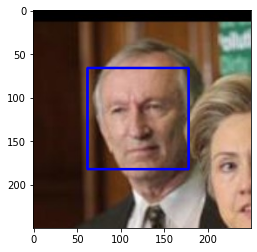

In [5]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier(haarcascades_path)

# load color (BGR) image
pic = cv2.imread(human_pix[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(pic, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x, y, w, h) in faces:
  # add bounding box to color image
  cv2.rectangle(pic, (x, y), (x + w, y + h), (255, 0, 0), 2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [0]:
# define human_face_detector function, which returns true if a human face is detected
def human_face_detector(pic_path):
  return len(
      face_cascade.detectMultiScale(
        cv2.cvtColor(
            cv2.imread(pic_path), cv2.COLOR_BGR2GRAY
            ))) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.


__Answer:__ 

In [7]:
# get first 100 images from each image set
human_pix_short = human_pix[:100]
dog_pix_short = dog_pix[:100]

# define a function called detect that takes a set of images as input,
# and returns the count of how many contained a human face
def detect(images):
  count = 0
  for i in tqdm(images):
    if human_face_detector(i):
      count += 1
  return count

# run the detect function on human_pix_short and dog_pix_short, and print the results
print("\nHuman face(s) detected in the first 100 images from: \nhuman_pix: {} \tdog_pix: {}".format(
  detect(human_pix_short), detect(dog_pix_short)))

100%|██████████| 100/100 [00:05<00:00, 16.80it/s]


Human face(s) detected in the first 100 images from: 
human_pix: 99 	dog_pix: 15


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [0]:
# move VGG16 to cuda if available
if use_cuda:
  VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [0]:
def preProcessPic(i):
  # open incoming image with PIL
  pic = Image.open(i)

  # find image height & width
  width = pic.size[0]
  height = pic.size[1] 

  # resize image using PIL's Image.thumbnail method with the LANCZOS resampling filter option
  x, y = (256, 1000) if width > height else (1000, 256)
  pic.thumbnail([x, y], Image.LANCZOS)
  
  # set image margins
  left = 0.5 * (pic.width - 224)
  bottom = 0.5 * (pic.height - 224)
  right = left + 224
  top = bottom + 224

  # crop image
  _ = pic.crop((left, bottom, right, top))

  # normalize, transpose, and return
  pic_array = np.array(pic) / 255
  return ((pic_array - np.mean(pic_array)) / np.std(pic_array)).transpose(2, 0, 1)

def VGG16_predict(pic_path):
  # preprocess incoming image
  pic = preProcessPic(pic_path)

  # convert to tensor
  pic = torch.from_numpy(pic).type(torch.FloatTensor)
  pic.unsqueeze_(0)

  # load image into cuda if available
  if use_cuda:
    pic = pic.cuda()

  # predict label
  probs = torch.exp(VGG16.forward(pic)) 
  _, label = probs.topk(1)     
  
  # return index of predicted class
  return label 

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [0]:
# define dog_detector function, which returns true if VGG16 detects a dog in the image
def dog_detector(pic_path):
  return((False, True) [151 <= int(VGG16_predict(pic_path)) <= 268])

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [11]:
# define a function called detect, that takes a set of images as input,
# and returns the count of how many contained a dog
def detect(images):
  count = 0
  for i in tqdm(images):
    if dog_detector(i):
      count += 1
  return count

# run the detect function on human_pix_short and dog_pix_short, and print the results
print('\nDog(s) detected in the first 100 images from: \nhuman_pix: {} \tdog_pix: {}'.format(
  detect(human_pix_short), detect(dog_pix_short)))


100%|██████████| 100/100 [00:13<00:00,  7.52it/s]


Dog(s) detected in the first 100 images from: 
human_pix: 0 	dog_pix: 95


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.
<!-- 
We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="https://github.com/JamesDBartlett/deep-learning-v2-pytorch/blob/master/project-dog-classification/images/Brittany_02625.jpg?raw=1" width="100"> | <img src="https://github.com/JamesDBartlett/deep-learning-v2-pytorch/blob/master/project-dog-classification/images/Welsh_springer_spaniel_08203.jpg?raw=1" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  


Curly-Coated Retriever | American Water Spaniel
- | -
<img src="https://github.com/JamesDBartlett/deep-learning-v2-pytorch/blob/master/project-dog-classification/images/Curly-coated_retriever_03896.jpg?raw=1" width="200"> | <img src="https://github.com/JamesDBartlett/deep-learning-v2-pytorch/blob/master/project-dog-classification/images/American_water_spaniel_00648.jpg?raw=1" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  


Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="https://github.com/JamesDBartlett/deep-learning-v2-pytorch/blob/master/project-dog-classification/images/Labrador_retriever_06457.jpg?raw=1" width="150"> | <img src="https://github.com/JamesDBartlett/deep-learning-v2-pytorch/blob/master/project-dog-classification/images/Labrador_retriever_06455.jpg?raw=1" width="240"> | <img src="https://github.com/JamesDBartlett/deep-learning-v2-pytorch/blob/master/project-dog-classification/images/Labrador_retriever_06449.jpg?raw=1" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.   -->

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [0]:
# Skip from-scratch model?
skipScratch = False

In [0]:
# specify transforms
data_transforms = {
  'train': transforms.Compose([        
      transforms.ColorJitter(brightness = 0.25, contrast = 0.25, saturation = 0.25),
      transforms.RandomRotation(23),
      transforms.RandomResizedCrop(224),
      transforms.RandomHorizontalFlip(),
      transforms.RandomVerticalFlip(),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], 
                            [0.229, 0.224, 0.225])]),
  'valid': transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], 
                            [0.229, 0.224, 0.225])]),
  'test': transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], 
                            [0.229, 0.224, 0.225])])}

# create a single variable for adjusting all of the co-dependent 
# convolutional values at once, thereby avoiding typos & mismatches
volume_knob_init = 32
volume_knob = [x * volume_knob_init for x in [1, 2, 4, 8, 16, 32, 64]]

# output of Net should be this shape & size
net_shape = 7**2
net_size = volume_knob[2]

# declare image directories
dirs = {'train': 'dogImages' + ddl + 'dogImages' + ddl + 'train', 
        'valid': 'dogImages' + ddl + 'dogImages' + ddl + 'valid',
        'test': 'dogImages' + ddl + 'dogImages' + ddl + 'test'}

# create training, validation, and test datasets
image_datasets = {x: datasets.ImageFolder(dirs[x], 
  transform = data_transforms[x]) for x in ['train', 'valid', 'test']}

# create dataloaders for training, validation, and test datasets
loaders_scratch = {x: torch.utils.data.DataLoader(image_datasets[x], 
  batch_size = net_size, shuffle = True) for x in ['train', 'valid', 'test']}

# store the sizes of training, validation, and test datasets in dataset_sizes variable
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}

# extract the image class names from the training dataset
class_names = image_datasets['train'].classes

# count the number of classes in the training dataset
num_classes = len(image_datasets['train'])

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?



---

**Answer**:

My code resizes the images by a combination of resizing & cropping. I chose 224 for the input tensor size because it is large enough to retain significantly more detail than the usual thumbnail-size images (like CIFAR or MNIST), but is still small enough that training the model doesn't take forever. It's also the dimensions that many of the pretrained models use, so this helps ensure we're comparing apples to apples. If I had unlimited computing power, I would much prefer my input tensors to be sized to the average dimensions of all images in the dataset, but that's not realistic, so I struck a compromise.

- For the training images, I added:
 1. 25% jitter on brightness, contrast, and saturation
 2. 23° random rotation
 3. 224px random resized crop
 4. random horizontal & vertical flips
 5. conversion to tensor
 6. normalization using the default values

- For the validation images, I added:
 1. 256px resize
 2. 224px center crop
 3. conversion to tensor
 4. normalization using the default values

- For the testing images, I added:
 1. 256px resize
 2. 224px center crop
 3. conversion to tensor
 4. normalization using the default values
 
---


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [0]:
# declare "Net" class, of type "nn.Module"
class Net(nn.Module):
  
  # define model architecture
  def __init__(self):
    super(Net, self).__init__()

    # four convolution layers
    self.conv1 = nn.Conv2d(3, volume_knob[0], 3, padding=1)
    self.conv2 = nn.Conv2d(volume_knob[0], volume_knob[1], 3, padding=1)
    self.conv3 = nn.Conv2d(volume_knob[1], volume_knob[2], 3, padding=1)
    self.conv4 = nn.Conv2d(volume_knob[2], volume_knob[2], 3, padding=1)

    # three fully-connected layers
    self.fc1 = nn.Linear(net_shape * volume_knob[6], volume_knob[4])
    self.fc2 = nn.Linear(volume_knob[4], volume_knob[4])
    self.fc3 = nn.Linear(volume_knob[4], num_classes) 
  
    # maxpool (with 2 x 2 geometry)
    self.pool = nn.MaxPool2d(2, 2)

    # dropouts (with 22%, 33%, or 44% chance)
    self.dropout22 = nn.Dropout(0.22)
    self.dropout33 = nn.Dropout(0.33)
    self.dropout44 = nn.Dropout(0.44)

  def forward(self, x):

    # run relu activation function on all four convolution layers, 
    # with a pooling step after each one, followed by a dropout
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = F.relu(self.conv3(x))
    x = self.pool(x)
    x = F.relu(self.conv4(x))
    x = self.dropout33(x)

    # flatten convolution output before fully-connected layers
    x = x.view(-1, net_shape * volume_knob[6])

    # run relu activation function on the first two fully-connected layers,
    # with a dropout step after each one, then return the third fully-connected layer
    x = F.relu(self.fc1(x))
    x = self.dropout44(x)
    x = F.relu(self.fc2(x))
    x = self.dropout22(x)
    x = self.fc3(x)
    return x

# instantiate the model
model_scratch = Net()

# print the model architecture
print(model_scratch)

# move model to cuda, if available
if use_cuda:
  model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=6680, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout22): Dropout(p=0.22, inplace=False)
  (dropout33): Dropout(p=0.33, inplace=False)
  (dropout44): Dropout(p=0.44, inplace=False)
)


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  



---


__Answer:__  
1. Created a variable array called `volume_knob[]` to take the place of all the numerical settings in the model architecture, so that I could make the necessary adjustments in one place, and have the values cascade all the way down through the model. 
2. Added 4 convolutional layers, because 3 didn't seem like quite enough, and 5 would have been too many!  
3. Added 3 fully-connected layers, because it felt like a good number, and the tests that I performed with the model seemed to confirm that idea.
4. Added a bit of healthy chaos to the dropout steps, with 3 distinct dropout functions -- each having a different chance of causing a dropout when called.


---



### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [0]:
# select the CrossEntropy loss function
criterion_scratch = nn.CrossEntropyLoss()

# select the Adam optimizer with the amsgrad option set to True
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr = 1e-3, amsgrad = True)

# reduce learning rate after 2 epochs of non-decreasing validation loss
scheduler_scratch = lr_scheduler.ReduceLROnPlateau(
    optimizer_scratch, mode = 'min', 
    patience = 2, factor = 1e-2, min_lr = 1e-4
    )

if use_cuda:
  criterion_scratch = criterion_scratch.cuda()

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pth'`.

In [0]:
# declare two empty dictionaries to keep track of the losses and accuracies
# of the training, validation, and test datasets, across all epochs.
all_losses = {'epoch': [], 'train': [], 'valid': [], 'test': []}
all_accuracies = {'epoch': [], 'train': [], 'valid': [], 'test': []}

# define the train function
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
  
  # initialize validation loss as infinity
  valid_loss_min = np.Inf 

  # print current time
  current_time() 
  
  # define the steps for each epoch
  for epoch in range(1, n_epochs + 1):
    all_losses['epoch'].append(epoch)
    all_accuracies['epoch'].append(epoch)
    start_time = time.time()
    horizBar('-', 84)
    print(f"Epoch: {epoch}")
    
    # initialize training and validation loss variables with floating-point zeros
    train_loss, valid_loss, train_running_corrects, valid_running_corrects = floatingZeros(4)
    
    # train the model
    model.train()

    # perform the following actions on the training dataloader's inputs & target
    for batch_idx, (data, target) in enumerate(loaders_scratch['train']):

      # use cuda, if available
      if use_cuda:
        data, target = data.cuda(), target.cuda()
                
      # zero out gradients
      optimizer_scratch.zero_grad()

      # pass inputs to model, get predictions (forward pass)
      outputs = model_scratch(data)
      _, preds = torch.max(outputs, 1)

      # calculate loss
      loss = criterion_scratch(outputs, target)

      # backward pass
      loss.backward()

      # run the optimizer to update the parameters
      optimizer_scratch.step()

      # update loss & running corrects 
      train_loss += data.size(0) * loss.item()
      train_running_corrects += torch.sum(preds == target.data)   
  
    # evaluate the model
    model.eval()

    # perform the following actions on the validation dataloader's inputs & target
    for batch_idx, (data, target) in enumerate(loaders_scratch['valid']):

      # move to cuda, if available
      if use_cuda:
        data, target = data.cuda(), target.cuda()

      # pass inputs to model, get predictions (forward pass)
      outputs = model_scratch(data)
      _, preds = torch.max(outputs, 1)

      # calculate loss
      loss = criterion_scratch(outputs, target)

      # update loss & running corrects variables
      valid_loss += data.size(0) * loss.item()
      valid_running_corrects += torch.sum(preds == target.data)
        
    # calculate and store average accuracies and losses for the training & validation datasets
    train_acc = train_running_corrects.double() / len(loaders_scratch['train'].dataset)
    all_accuracies['train'].append(train_acc)
    valid_acc = valid_running_corrects.double() / len(loaders_scratch['valid'].dataset)
    all_accuracies['valid'].append(valid_acc)
    train_loss /= len(loaders_scratch['train'].dataset)
    all_losses['train'].append(train_loss)
    valid_loss /= len(loaders_scratch['valid'].dataset)
    all_losses['valid'].append(valid_loss)

    # update time it took the epoch to run
    time_epoch = time.time() - start_time
        
    # print results
    # print("Training Loss: {:.6f} \tValidation Loss: {:.6f} \tTime: {:.0f}m {:.0f}s".format(             
    #   train_loss, valid_loss, time_epoch // 60, time_epoch % 60))
    printLosses(train_loss, valid_loss)
    
    # if validation loss decreased, save model & update valid_loss_min variable
    # if valid_loss_min > valid_loss:
    #   print("Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(valid_loss_min, valid_loss))
    #   torch.save(model_scratch.state_dict(), 'model_scratch.pth')
    #   valid_loss_min = valid_loss  
    valid_loss_min = validLossEval(valid_loss_min, valid_loss, model_scratch, 'model_scratch.pth')

    # print time it took the epoch to run
    printEpochTime(time_epoch)

    horizBar('-', 84)     

    # Print the current time every 3rd epoch
    if epoch % 3 == 0:
      current_time() 
          
  return model

# move model to cuda, if available
if use_cuda:
  model_scratch = model_scratch.cuda()
  
# skip training if skipScratch is True
if not (skipScratch):

  # Skip training if the model file already exists
  if not (path.exists('model_scratch.pth')):

    # train model
    model_scratch = train(30, loaders_scratch, model_scratch, optimizer_scratch, 
                          criterion_scratch, use_cuda, 'model_scratch.pth')
  # load model with highest accuracy
  model_scratch.load_state_dict(torch.load('model_scratch.pth'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [0]:
# define test function
def test(loaders, model, criterion, use_cuda):

  # initialize testing loss variables with floating-point zeros
  test_loss, correct, total = floatingZeros(3)

  # evaluate the model
  model.eval()

  # perform the following actions on the testing dataloader's inputs & target
  for batch_idx, (data, target) in enumerate(loaders['test']):

    # move to cuda, if available
    if use_cuda:
      data, target = data.cuda(), target.cuda()

    # pass data to model, get output (forward pass)
    output = model(data)

    # calculate loss
    loss = criterion(output, target)

    # update test loss variable
    test_loss += (loss.data - test_loss) * (1 / (batch_idx + 1))

    # predict class from output
    pred = output.data.max(1, keepdim = True)[1]

    # check predicted class against actual class
    correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
    total += data.size(0)

  # print results        
  # print(f"Test Loss: {test_loss:.6f}\n")
  # print("\nTest Accuracy: %2d%% (%2d/%2d)" % (100 * correct / total, correct, total))
  printTestResults(test_loss, correct, total)


# skip testing if skipScratch is True
if not (skipScratch):

  # call test function    
  test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [0]:
# declare image directories
dirs = {'train': 'dogImages' + ddl + 'dogImages' + ddl + 'train', 
        'valid': 'dogImages' + ddl + 'dogImages' + ddl + 'valid',
        'test': 'dogImages' + ddl + 'dogImages' + ddl + 'test'}
        
# specify transforms
data_transforms = {
  'train': transforms.Compose([        
      transforms.ColorJitter(brightness = 0.25, contrast = 0.25, saturation = 0.25),
      transforms.RandomRotation(15), transforms.RandomResizedCrop(224),
      transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(), transforms.ToTensor(), 
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
  'valid': transforms.Compose([
      transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
  'test': transforms.Compose([
      transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}

# create training, validation, and test datasets
image_datasets = {x: datasets.ImageFolder(dirs[x], 
  transform = data_transforms[x]) for x in ['train', 'valid', 'test']}

# create dataloaders for training, validation, and test datasets
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
  batch_size = 64, shuffle = True) for x in ['train', 'valid', 'test']}

# store the sizes of training, validation, and test datasets in dataset_sizes variable
dataset_sizes = {x: len(image_datasets[x]) 
  for x in ['train', 'valid', 'test']}
    
# extract the image class names from the training dataset    
class_names = image_datasets['train'].classes

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [0]:
# Initialize model
model_transfer = densenet161            
# model_transfer = wide_resnet50        
# model_transfer = wide_resnet101       
# model_transfer = resnext101

# move model to cuda, if available
if use_cuda:
  model_transfer = model_transfer.cuda()

# declare classifier as nn.Sequential object, containing an OrderedDict of layers to use in the model
classifier = nn.Sequential(
  OrderedDict([('fc1',
                nn.Linear(model_transfer.classifier.in_features,
                          model_transfer.classifier.out_features)),
              ('relu', nn.ReLU()), 
              ('bn', 
                nn.BatchNorm1d(model_transfer.classifier.out_features)),                        
              ('fc2',
                nn.Linear(model_transfer.classifier.out_features,
                         len(class_names))),
              ('relu', nn.ReLU()), 
              ('output', nn.LogSoftmax(dim = 1))]))

# turn off training on feature layers
for param in model_transfer.features.parameters():
  param.requires_grad = False
  
# set model_transfer's classifier to previously-declared classifier object
model_transfer.classifier = classifier

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.



---


__Answer:__ 


1. I used the same image_datasets, dataloaders, dataset_sizes, class_names, and data_transforms from the previous model, to keep the comparison between them as fair as possible.
2. I decided to use DenseNet for my pretrained model because it's fast, and also because it was trained on ImageNet, which makes it a good starting place for image classification problems like this.
3. I replaced the model's pretrained classification layers with the following: 
 - 1 fully-connected layer as the input
 - 1 relu activation function
 - 1 BatchNorm1d layer
 - 1 fully-connected layer
 - 1 relu activation function
 - 1 LogSoftMax function as the output

---




### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [0]:
# select the CrossEntropy loss function
criterion_transfer = nn.CrossEntropyLoss()

# select the Adam optimizer with the amsgrad option set to True
optimizer_transfer = optim.Adam(model_transfer.classifier.parameters(), lr = 1e-3, amsgrad = True)

# reduce learning rate after 2 epochs of non-decreasing validation loss
scheduler_transfer = lr_scheduler.ReduceLROnPlateau(
    optimizer_transfer, mode = 'min', 
    patience = 2, factor = 1e-2, min_lr = 1e-4
    )

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [0]:
# declare two empty dictionaries to keep track of the losses and accuracies
# of the training, validation, and test datasets, across all epochs.
all_losses = {'epoch': [], 'train': [], 'valid': [], 'test': []}
all_accuracies = {'epoch': [], 'train': [], 'valid': [], 'test': []}

# move model to cuda, if available
if use_cuda:
  model_transfer = model_transfer.cuda()

# Skip training if the model file already exists
if not (path.exists('model_transfer.pth')):

  # set number of training epochs to 10
  n_epochs = 10

  # initialize validation loss as infinity
  valid_loss_min = np.Inf

  # print the current time
  current_time()

  # define the steps for each epoch
  for epoch in range(1, n_epochs + 1):    
    all_losses['epoch'].append(epoch)
    all_accuracies['epoch'].append(epoch)
    start_time = time.time()
    horizBar('-', 84)
    print('Epoch: {}'.format(epoch))

    # initialize training and validation loss variables with floating-point zeros
    train_loss, valid_loss, train_running_corrects, valid_running_corrects = floatingZeros(4)
    
    # train the model 
    model_transfer.train()

    # perform the following actions on the training dataloader's inputs & target
    for inputs, target in dataloaders['train']:

      # move to cuda, if available
      inputs, target = inputs.cuda(), target.cuda()

      # zero out gradients
      optimizer_transfer.zero_grad()

      # pass inputs to model, get predictions (forward pass)
      outputs = model_transfer(inputs)
      _, preds = torch.max(outputs, 1)

      # calculate loss
      loss = criterion_transfer(outputs, target)

      # backward pass
      loss.backward()

      # run the optimizer to update the parameters
      optimizer_transfer.step()

      # update loss & running corrects variables
      train_loss += inputs.size(0) * loss.item()
      train_running_corrects += torch.sum(preds == target.data)        
        
    # evaluate the model
    model_transfer.eval()

    # perform the following actions on the validation dataloader's inputs & target
    for inputs, target in dataloaders['valid']:

      # move to cuda if available
      if use_cuda:
        inputs, target = inputs.cuda(), target.cuda()

      # pass inputs to model, get predictions (forward pass)
      outputs = model_transfer(inputs)
      _, preds = torch.max(outputs, 1)

      # calculate loss
      loss = criterion_transfer(outputs, target)

      # update loss & running corrects variables
      valid_loss += inputs.size(0) * loss.item()
      valid_running_corrects += torch.sum(preds == target.data)
    
    # calculate and store average accuracies and losses for the training & validation datasets
    train_acc = train_running_corrects.double() / len(dataloaders['train'].dataset)
    all_accuracies['train'].append(train_acc)
    valid_acc = valid_running_corrects.double() / len(dataloaders['valid'].dataset)
    all_accuracies['valid'].append(valid_acc)
    train_loss /= len(dataloaders['train'].dataset)
    all_losses['train'].append(train_loss)
    valid_loss /= len(dataloaders['valid'].dataset)
    all_losses['valid'].append(valid_loss)
    
    # calculate the time it took the epoch to run
    time_epoch = time.time() - start_time
        
    # print losses & accuracies
    printLosses(train_loss, valid_loss)
    printAccuracies(train_acc, valid_acc)

    # if validation loss decreased, save model & update valid_loss_min variable      
    valid_loss_min = validLossEval(valid_loss_min, valid_loss, model_transfer, 'model_transfer.pth')

    # print the time it took the epoch to run
    printEpochTime(time_epoch)

    horizBar('-', 84) 

    # Print the current time every other epoch
    if epoch % 2 == 0:
      current_time()

# load model with highest accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pth'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [0]:
# initialize testing loss and running corrects variables with floating-point zeros
test_loss, test_running_corrects = floatingZeros(2)

# test the model
model_transfer.eval()

# perform the following actions on the testing dataloader's inputs & target
for inputs, target in dataloaders['test']:

  # move to cuda, if available
  if use_cuda:
    inputs, target = inputs.cuda(), target.cuda()

  # pass inputs to model, get predictions (forward pass)
  outputs = model_transfer(inputs)
  _, preds = torch.max(outputs, 1)

  # calculate loss
  loss = criterion_transfer(outputs, target)

  # update loss & running corrects variables 
  test_loss += inputs.size(0) * loss.item()
  test_running_corrects += torch.sum(preds == target.data)

# calculate and store average accuracies and losses for the testing dataset
test_acc = test_running_corrects.double() / len(dataloaders['test'].dataset)
all_accuracies['test'].append(test_acc)
test_loss /= len(dataloaders['test'].dataset)
all_losses['test'].append(test_loss)

# print results
print(f"Test Loss: {test_loss:.6f} \tTest Accuracy: {(test_acc * 100):.6f}")

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [0]:
# replace underscores in class_names with spaces, and store the results back into class_names
class_names = [item[4:].replace("_", " ") for item in class_names]

# define predict_breed_transfer function, which takes a single image as its argument
def predict_breed_transfer(pic_path):
  
  # pre-process the input image
  pic = preProcessPic(pic_path) 

  # convert it to a tensor
  pic = torch.from_numpy(pic).type(torch.FloatTensor) 
  pic.unsqueeze_(0)

  # move the tensor to cuda, if available
  if use_cuda:
    pic = pic.cuda()

  # predict image label
  probs = torch.exp(model_transfer.forward(pic)) 
  _, label = probs.topk(1)     
  return class_names[int(label)]

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

<!-- Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](https://github.com/JamesDBartlett/deep-learning-v2-pytorch/blob/master/project-dog-classification/images/sample_human_output.png?raw=1) -->


### (IMPLEMENTATION) Write your Algorithm

In [0]:
# define run_app function, which takes a single image as its argument
def run_app(pic_path):

  # display the input image
  display.display(display.Image(filename = pic_path, width = 256))
  
  # if subject is human, indicate so, then say what dog breed they look most like
  if human_face_detector(pic_path):
    print("Human detected. Dog breed this human looks most like: ")

  # if subject is a dog, indicate so, then predict its breed
  elif dog_detector(pic_path):
    print("Dog detected. Most likely breed: ")
  
  # otherwise, indicate that no humans or dogs were found, and return null
  else:
    print("Humans and/or dogs found in this photo:")
    return

  # return predicted dog breed of the detected human or dog
  return predict_breed_transfer(pic_path)

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.



---


__Answer:__  


I thought my model performed very well, though it could certainly be improved. Here are 3 ways I might improve it in the future:
1. Increase the number of training epochs until the model's prediction accuracy comes to a plateau.
2. Experiment with using other pretrained models, like resnext101_32x8d, or one of the wide_resnet models.
3. Experiment with adding, removing, or changing the fully-connected layers and the output layer.


---



### Test using images from the original (udacity-aind/dog-project) datasets

In [0]:
horizBar('*', 84)

print("\nAnalyzing images from human_pix and dog_pix datasets...\n")

# pick 10 random images from each of the human_pix and dog_pix datasets
random_humans = random.sample(list(human_pix), 10)
random_dogs = random.sample(list(dog_pix), 10)

# call run_app function on the contents of the random_humans and random_dogs arrays
for file in np.hstack((random_humans[:10], random_dogs[:10])):
  horizBar('-', 84)
  print(" - " + run_app(file) + "\n")
  horizBar('-', 84)

### Test using trending images from the following categories on [stocksnap.io](https://stocksnap.io):

*   dog
*   woman face
*   man face
*   fruit
*   car



In [0]:
print("\nDownloading and analyzing images from custom dataset (stocksnap.io)...\n")

# declare variable for test images folder name
test_images = 'test-images'

# create test-images folder, if it doesn't already exist
if not (path.exists(test_images)):
  os.mkdir(test_images)

# from stocksnap.io, download 5 random images from each of these 5 categories: 
## dog, woman face, man face, fruit, car 
# save the images in the test-images folder, and log any errors to test-images-download-log.txt
!image-scraper -m 5 -s "test-images" "https://stocksnap.io/search/dog/sort/trending/desc" \
  --formats jpg --scrape-reverse >> test-images-download-log.txt
!image-scraper -m 5 -s "test-images" "https://stocksnap.io/search/woman+face/sort/trending/desc" \
  --formats jpg --scrape-reverse >> test-images-download-log.txt
!image-scraper -m 5 -s "test-images" "https://stocksnap.io/search/man+face/sort/trending/desc" \
  --formats jpg --scrape-reverse >> test-images-download-log.txt
!image-scraper -m 5 -s "test-images" "https://stocksnap.io/search/fruit/sort/trending/desc"  \
  --formats jpg --scrape-reverse >> test-images-download-log.txt
!image-scraper -m 5 -s "test-images" "https://stocksnap.io/search/car/sort/trending/desc"  \
  --formats jpg --scrape-reverse >> test-images-download-log.txt

# create list of all jpg images in test-images folder
testImageList = [f for f in os.listdir(test_images) if f.endswith('.jpg')]

print()
horizBar('*', 90)
print("\tNOTE:")
print(f"\tThere are currently {len(testImageList):0d} images in the testImageList dataset.")
print("\tTo download more images and add them to the dataset, run this cell again.")
horizBar('*', 90)

In [0]:
# pick 25 images at random from testImageList
testImageList = random.sample(list(testImageList), 25)

# iterate over the image list
for i in testImageList:

  horizBar('-', 84)

  # call run_app function, pass current image as argument, print output
  print(" - " + run_app(test_images + ddl + i) + "\n")

  horizBar('-', 84)